## VAE with Gaussian Distribuition Data

In [2]:
import timeit
start_time = timeit.default_timer()
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F # type: ignore
import numpy as np
from torchvision.utils import save_image
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

debug = False


cuda


##### Dados
Criando dados de uma distribuição normal ```xTrain``` (utilizado no treinamento), ```xVal``` (utilizado na validação do modelo).


In [94]:
nVar = 1                                                # NOTE: The number of variables(features) in the input data. Tensor shape: (nSamples, nVar) Example: data.shape[1] = nVar

nTrain = 100000  
nVal = 20000
nTest = nVal

x_train = torch.normal(5, 2, size=(nTrain, nVar)).to(device) 
x_val = torch.normal(5, 2, size=(nVal, nVar)).to(device)
x_test = torch.normal(5, 2, size=(nTest, nVar)).to(device) 

x_test

tensor([[5.1041],
        [7.0737],
        [4.0991],
        ...,
        [4.0999],
        [7.2169],
        [3.9893]], device='cuda:0')

##### Carregando os dados

DataLoaders funcionam iterando sobre o dataset.

```Batch_size``` é a quantidade de dados que será pego a cada iteração.

 ```shuffle=True``` é importante para pegar sempre um set de dados aleatório a cada iteração.

In [95]:
batch_size = 100

trainLoader = torch.utils.data.DataLoader(x_train, batch_size=batch_size, shuffle=True)
valLoader = torch.utils.data.DataLoader(x_val, batch_size=batch_size, shuffle=False)
testLoader = torch.utils.data.DataLoader(x_test, batch_size=batch_size, shuffle=False)



##### Definição da Arquitetura VAE

In [96]:
from typing import Union

class VAE(nn.Module):
    def __init__(self, nVar: int, h_dims, z_dim: int, activation: Union[nn.ReLU, nn.Sigmoid, nn.Tanh, nn.LeakyReLU, nn.ELU]):
        super().__init__()
        """Defines the architecture of the VAE
        Args:
            h_dims: list of hidden dimensions
            z_dim: dimension of the latent space
            nVar: dimension of the input data
        """
        
        # Encoder construction
        encoder_layers = []
        input_dim = nVar
        for h in h_dims:
            encoder_layers.append(nn.Linear(input_dim, h))
            encoder_layers.append(activation)
            input_dim = h
            
        self.encode_layers = nn.Sequential(*encoder_layers)
        
        self.fc_mu = nn.Linear(h_dims[-1], z_dim)
        self.fc_logvar = nn.Linear(h_dims[-1], z_dim)

        # Decoder construction
        decoder_layers = []
        # Start from z_dim, go through h_dims in reverse
        input_dim = z_dim
        for h in reversed(h_dims):
            decoder_layers.append(nn.Linear(input_dim, h))
            decoder_layers.append(activation)
            input_dim = h
        
        decoder_layers.append(nn.Linear(h_dims[0], nVar))               # NOTE: Layer final volta para o número de dimenções de entrada;
        
        self.decode_layers = nn.Sequential(*decoder_layers)

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)  # Fixed: convert log_var to std
        eps = torch.randn_like(std)
        return mu + eps * std

    def encoder(self, x):
        h = self.encode_layers(x)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def decoder(self, x):
        return self.decode_layers(x)  # Removed fc_output call
    


Loss Function

Mean Squered error + Kullback

In [97]:
def loss_function(recon_x, x, mu, std):
    # Loss function
    ERR = nn.MSELoss(reduction='sum')(recon_x, x)
    KLD = -0.5 * torch.sum(1 + torch.log(std**2) - mu**2 - std**2)
    return ERR + KLD, -ERR, -KLD

Sumarizarando : : 

| Step | Action | PyTorch Function |
| :-: | :-: | -: |
| 1 | Forward pass | ```model()``` |
| 2 | Compute loss | ```loss_function()``` |
| 3 | Backpropagate gradients | ```loss.backward()``` |
| 4 | Update weight | ```optimizer.step()``` |
| 5 | Clear gradients | ```optimizer.zero_grad()``` |


In [98]:
z_dim = 8


model = VAE(1, [64, 32, 16], z_dim, nn.Tanh()).to(device) #NOTE ENCODER PATH >> 1 → 32 → 16 → 3(mu/logvar)

##### The optimizer : : ADAM

In [99]:
optimizer = torch.optim.Adam(
        model.parameters(),
        lr = 0.002
    )

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                                    optimizer, 'max',
                                    factor=0.5,
                                    patience=5, threshold=0.001, cooldown=0,
                                    min_lr=0.0001, verbose=True
                                )

c:\Users\vinic\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [100]:
count=0
err_l, kld_l, n_wu, terrl, tkldl, update = [], [], [], [], [], []
for epoch in range(1, 20):

    train_loss = 0
    for batch_idx, (data) in enumerate(trainLoader):
        model.train()
        bsize = data.shape[0]
        recon_batch, mu, std = model(data)
        loss, err, kld = loss_function(recon_batch, data, mu, std)
        loss.backward()
        train_loss += err.item() + kld.item()
        optimizer.step()
        optimizer.zero_grad()
        err_l.append(err.item()/bsize)
        kld_l.append(kld.item()/bsize)
        count+=1
        n_wu.append(count)

        if (count%100 == 0): # Validating every 100 weight updates
          for batch_idx, datav in enumerate(valLoader):
            model.eval()
            trecon, tmu, tstd = model(datav)
            tloss, terr, tkld = loss_function(trecon, datav, tmu, tstd)
            terrl.append(terr.item()/datav.shape[0])
            tkldl.append(tkld.item()/datav.shape[0])
            update.append(count)

    scheduler.step(train_loss / len(trainLoader.dataset))

    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(trainLoader.dataset)))
    model.eval()
    test_loss= 0
    with torch.no_grad():
        for data in testLoader:
            recon, mu, std = model(data)
            loss, err, kld = loss_function(recon, data, mu, std)
            test_loss += err + kld

    test_loss /= len(testLoader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

====> Epoch: 1 Average loss: -2.7754
====> Test set loss: -1.5601
====> Epoch: 2 Average loss: -1.4881
====> Test set loss: -1.6163
====> Epoch: 3 Average loss: -1.4619
====> Test set loss: -1.4549
====> Epoch: 4 Average loss: -1.4549
====> Test set loss: -1.4717
====> Epoch: 5 Average loss: -1.4453
====> Test set loss: -1.4930
====> Epoch: 6 Average loss: -1.4468
====> Test set loss: -1.4374
====> Epoch: 7 Average loss: -1.4326
====> Test set loss: -1.4886
====> Epoch: 8 Average loss: -1.4324
====> Test set loss: -1.4536
====> Epoch: 9 Average loss: -1.4131
====> Test set loss: -1.4171
====> Epoch: 10 Average loss: -1.4048
====> Test set loss: -1.4015
====> Epoch: 11 Average loss: -1.3970
====> Test set loss: -1.3700
====> Epoch: 12 Average loss: -1.3840
====> Test set loss: -1.3966
====> Epoch: 13 Average loss: -1.3826
====> Test set loss: -1.4278
====> Epoch: 14 Average loss: -1.3863
====> Test set loss: -1.3898
====> Epoch: 15 Average loss: -1.3780
====> Test set loss: -1.3940
====

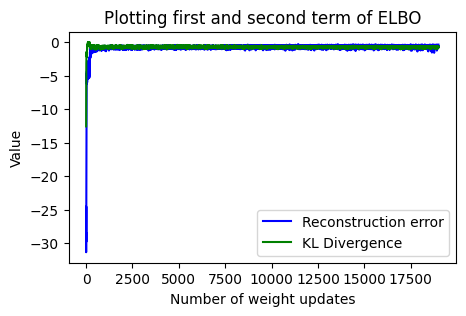

In [101]:
plt.figure(figsize=(5,3), dpi=100)
plt.plot(n_wu, err_l, 'b', label='Reconstruction error')
plt.plot(n_wu, kld_l, 'g', label='KL Divergence')
plt.title('Plotting first and second term of ELBO')
plt.xlabel('Number of weight updates')
plt.ylabel('Value')
plt.legend()

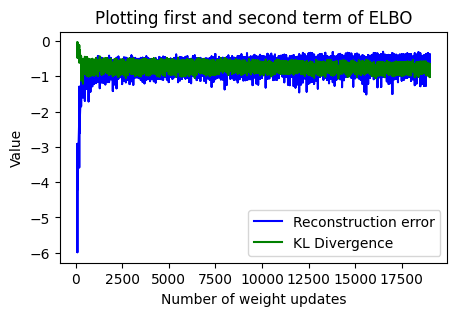

In [102]:
plt.figure(figsize=(5,3), dpi=100)
plt.plot(update, terrl, 'b', label='Reconstruction error')
plt.plot(update, tkldl, 'g', label='KL Divergence')
plt.title('Plotting first and second term of ELBO')
plt.xlabel('Number of weight updates')
plt.ylabel('Value')
plt.legend()

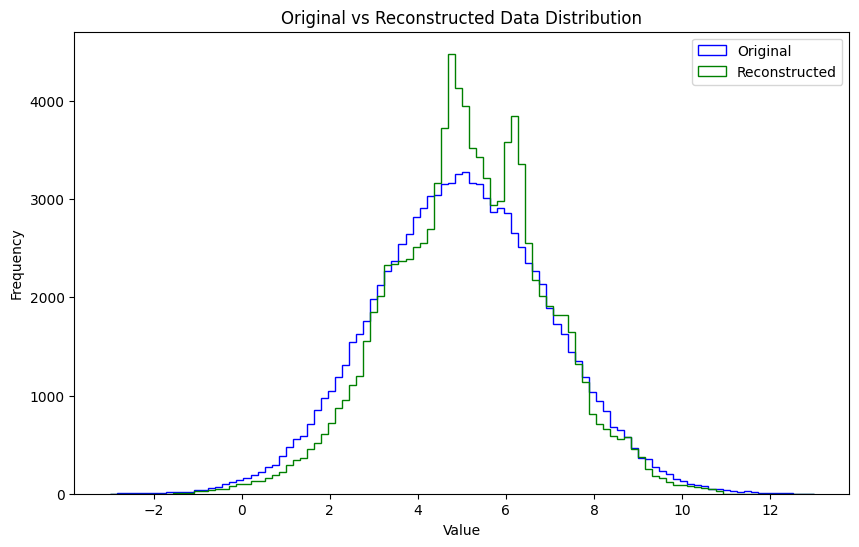

In [119]:
model.eval()  # Set model to evaluation mode

# Ensure input is on the same device as model
a = x_train.to(device)

# Get reconstruction
with torch.no_grad(): 
    recon, mu, logvar = model(a)
    std = torch.exp(0.5 * logvar)  # Convert log variance to std dev

# Move tensors to CPU for plotting if they're on GPU
a_np = a.cpu().numpy() if a.is_cuda else a.numpy()
recon_np = recon.cpu().numpy() if recon.is_cuda else recon.numpy()

# Plot histograms
plt.figure(figsize=(10, 6))
plt.hist(a_np[:, 0], bins=100, range=[-3, 13], histtype='step', color='blue', label='Original')
plt.hist(recon_np[:, 0], bins=100, range=[-3, 13], histtype='step', color='green', label='Reconstructed')
plt.legend()
plt.title('Original vs Reconstructed Data Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

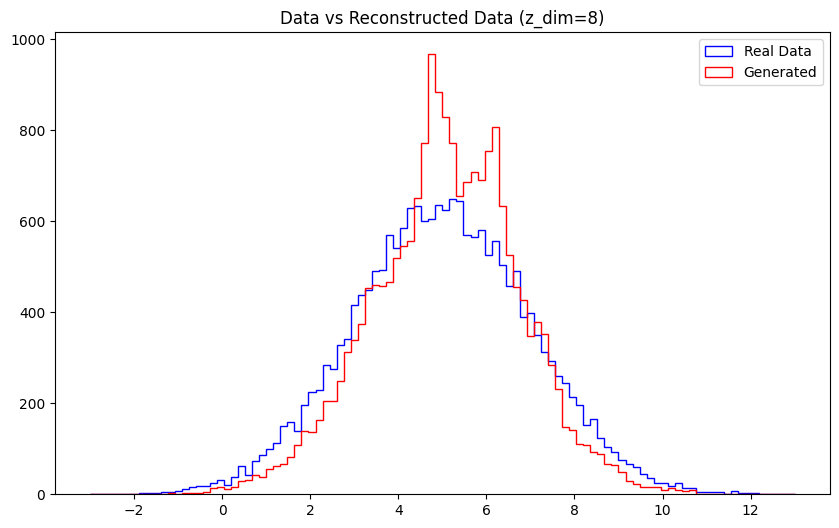

In [111]:
# Generate samples
model.eval()
with torch.no_grad():
    # Generate random latent vectors (MUST match z_dim)
    latent_samples = torch.randn(nVal, z_dim).to(device)
    generated = model.decoder(latent_samples)
    
    # Plot
    plt.figure(figsize=(10,6))
    plt.hist(x_test.cpu().numpy().flatten(), bins=100, range=[-3,13], 
             histtype='step', color='blue', label='Real Data')
    plt.hist(generated.cpu().numpy().flatten(), bins=100, range=[-3,13], 
             histtype='step', color='red', label='Generated')
    plt.legend()
    plt.title(f"Data vs Reconstructed Data (z_dim={z_dim})")
    plt.show()